In [2]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.dirname(os.path.abspath('')))  # similar-expressions/
sys.path.insert(0, project_root)

# Reload modules
from importlib import reload
from src.model import encoder, decoder
from src.utils import dataset, config, dev, dataset_dev, parsing, grammar
reload(decoder); reload(encoder); reload(dataset); reload(config); reload(dev); reload(dataset_dev); reload(parsing); reload(grammar); reload(grammar)

/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


<module 'src.utils.grammar' from '/mhome/damtp/q/lc865/workspace/similar-expressions/src/utils/grammar.py'>

In [62]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
from matplotlib import pyplot as plt
from omegaconf import OmegaConf

from src.utils.dataset_dev import load_wandb_model, dataloader_from_wandb_cfg, data_from_loader
from src.utils.dataset import create_value_transform
from src.utils.dev import plot_var_distributions, plot_latent_distribution

# Load model and dataset
model, cfg = load_wandb_model(run='e51hcsb9', name='epoch=57.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../train/config.yaml')
train_loader, test_loader, info = dataloader_from_wandb_cfg(cfg, max_length=int(1e6), allow_different_dataset_hash=True)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']
# FIXME: Currently saving arcsinh-transformed values during datagen so no additional transform is applied during training. Above value_transform is identity.
value_transform = create_value_transform(OmegaConf.create({'mapping': 'arcsinh', 'bias': None, 'scale': None}), None)

Imported model from run "e51hcsb9".
  | Name    | Type    | Params | Mode
-------------------------------------------
0 | encoder | Encoder | 8.9 M  | eval
1 | decoder | Decoder | 8.6 M  | eval
-------------------------------------------
17.5 M    Trainable params
0         Non-trainable params
17.5 M    Total params
70.150    Total estimated model params size (MB)
0         Modules in train mode
78        Modules in eval mode
Using dataset "dataset_250110_2" of size 900000
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 900000  | Batch: 512   | Batches: 1757 
  | valid        | Size: 100000  | Batch: 512   | Batches: 195  
---------------------------------------------------------------------


## Latent space distribution (+ samples for later use)

In [40]:
def encode_and_sample_dataset(model, data_loader, cfg, batch_size=2**15, max_data_len=None, calc_var_stats=False):
    if max_data_len is not None:
        assert batch_size <= max_data_len, 'Batch size must be less than max_data_len'
        num_samples = min(len(data_loader.dataset), max_data_len)
    else:
        num_samples = len(data_loader.dataset)

    print(f'Number of samples: {len(data_loader.dataset)} (dataloader), {num_samples} (encoded)')
    z_size = cfg.model.z_size
    
    mu = np.empty([num_samples, z_size])
    z = np.empty([num_samples, z_size])

    if calc_var_stats:
        mean_of_var = np.empty(num_samples)
        std_of_var = np.empty(num_samples)
    else:
        mean_of_var, std_of_var = None, None
    
    for i, x in enumerate(data_from_loader(data_loader, 'x', batch_size=batch_size, max_length=max_data_len)):
        mean, ln_var = model.encoder(x)
        
        start_idx, end_idx = i * batch_size, (i + 1) * batch_size

        mu[start_idx:end_idx, :] = mean.detach().numpy()
        z[start_idx:end_idx, :] = model.sample(mean, ln_var).detach().numpy()

        if calc_var_stats:
            var = ln_var.exp() * cfg.training.sampling.eps**2  # Effective var
            mean_of_var[start_idx:end_idx] = var.mean(dim=1).detach().numpy()
            std_of_var[start_idx:end_idx] = var.std(dim=1).detach().numpy()
    
    return mu, z, mean_of_var, std_of_var

mu_train, z_train, mean_of_var_train, std_of_var_train = encode_and_sample_dataset(model, train_loader, cfg, calc_var_stats=False, max_data_len=2**16)
mu_test, z_test, mean_of_var_test, std_of_var_test = encode_and_sample_dataset(model, test_loader, cfg, calc_var_stats=False, max_data_len=2**16)

Number of samples: 900000 (dataloader), 65536 (encoded)
Number of samples: 100000 (dataloader), 65536 (encoded)


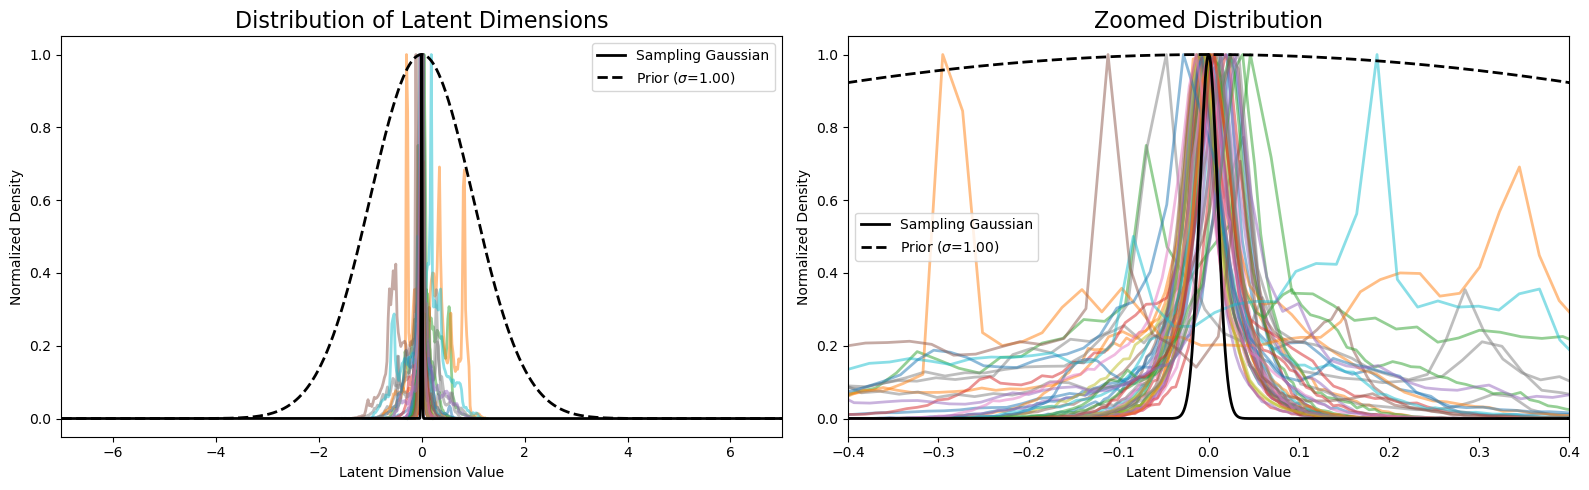

In [41]:
# plot_var_distributions(mean_of_var_train, mean_of_var_test, std_of_var_train, std_of_var_test)
plot_latent_distribution(mu_train, cfg)

## Examine neighbourhood in latent space of training samples 

Encode into latent space, sample from neighbourhood, decode expression and evaluate it.

In [51]:
from omegaconf import OmegaConf
value_transform = create_value_transform(OmegaConf.create({'mapping': 'arcsinh', 'bias': None, 'scale': None}), None)


Evaluating neighbourhood, might take a while.: 100%|██████████| 100/100 [00:00<00:00, 321.60it/s]


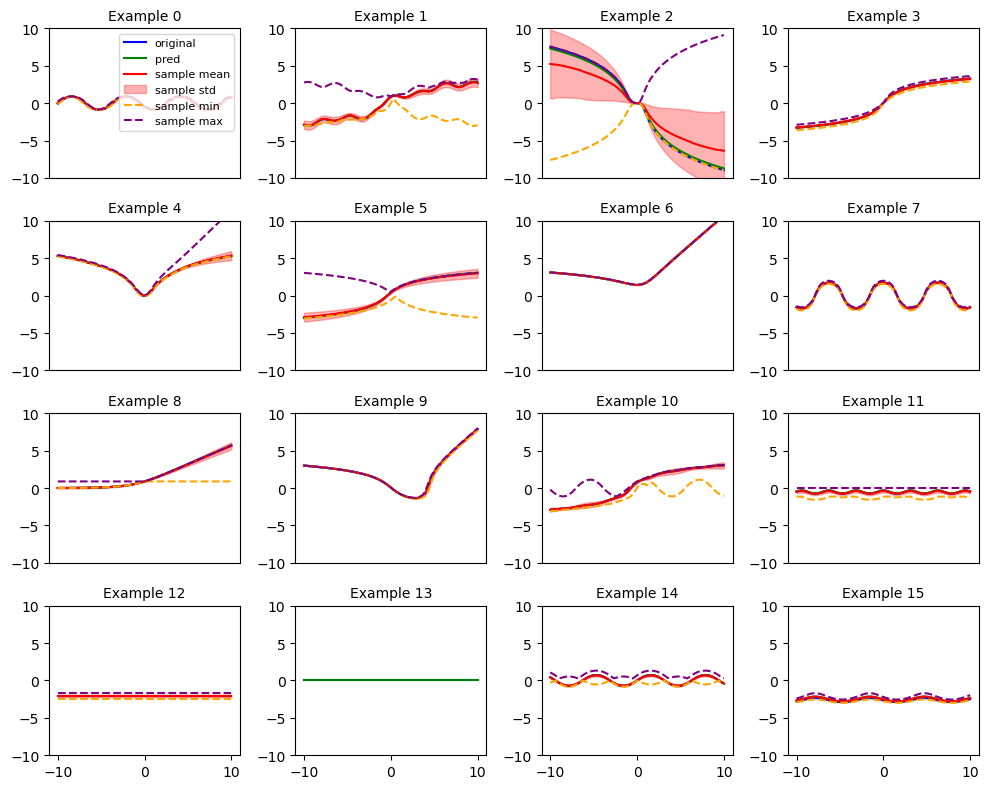

In [69]:
# Sampling with decoder -> eval
from src.utils.dev import calc_and_plot_samples_grid

model.sampling_eps = 3e-3

start_idx = 0
idx = range(start_idx, start_idx+16)
n_samples = 100

data_loader = train_loader
x = data_from_loader(data_loader, 'x', idx=idx)
values_true = data_from_loader(data_loader, 'values', idx=idx)

calc_and_plot_samples_grid(model, x, values_true, n_samples, idx, mode='syntax', val_x=val_x, value_transform=value_transform, var_multiplier=10, use_const_var=False)

## Mean distance

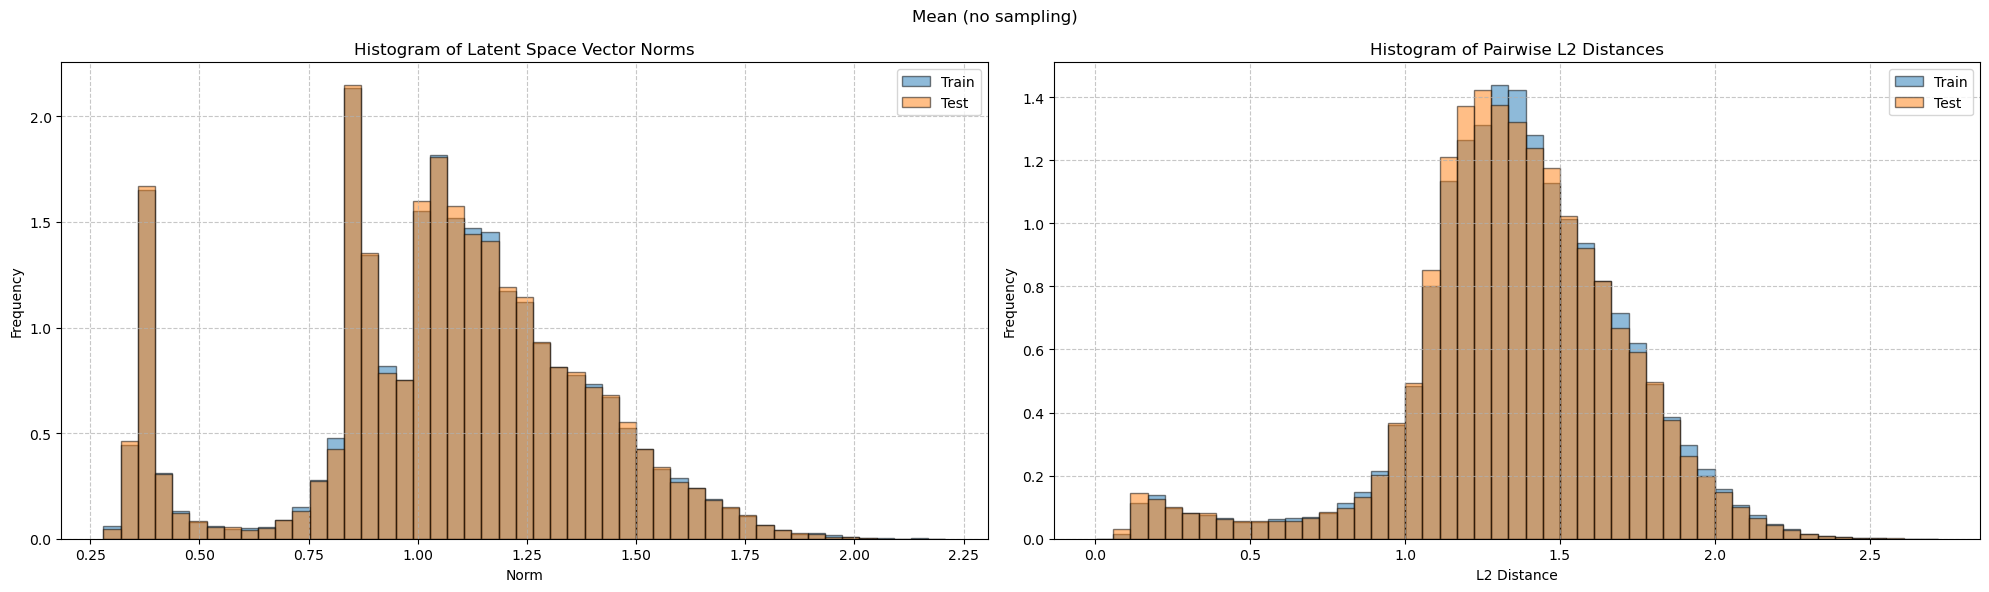

In [42]:
from src.utils.dev import plot_latent_distances

plot_latent_distances(mu_train, mu_test, 'Mean (no sampling)')

## Interpolation study

Distance: 1.4075554084756747


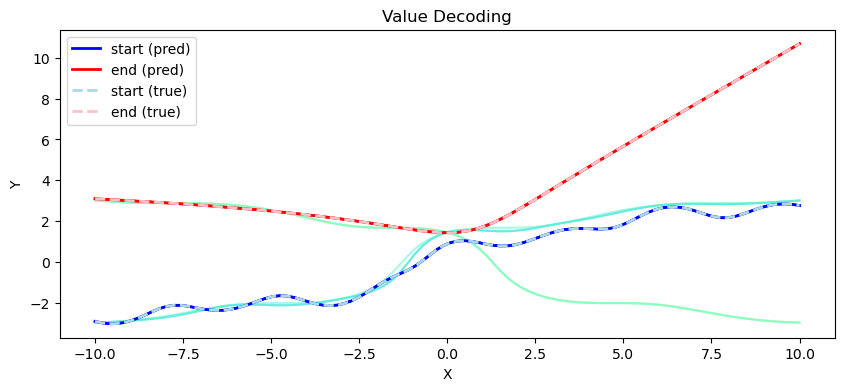

In [94]:
from src.utils.dev import plot_value_interpolation, slerp
from src.utils.parsing import logits_to_infix, eval_from_logits

# Parameters
i, j = 1, 6
num_steps = 30
interp_mode = 'slerp'

# Get data
z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()


print(f'Distance: {np.linalg.norm(z_end - z_start)}')

# Interpolate in latent space
alpha = np.linspace(0, 1, num_steps)
if interp_mode == 'slerp':
    z_interp = slerp(z_start, z_end, alpha)
elif interp_mode == 'linear':
    z_interp = z_start[np.newaxis, ...] * (1 - alpha[:, np.newaxis]) + z_end[np.newaxis, ...] * alpha[:, np.newaxis]
else:
    raise ValueError(f'Interpolation mode {interp_mode} not supported')

# Decode into values and logits
logits_interp = model.decoder(torch.tensor(z_interp.astype(np.float32)))
    
values_interp = torch.empty(size=(logits_interp.shape[0], val_x.shape[0]))
for idx in range(0, logits_interp.shape[0]):
    res = eval_from_logits(logits_interp[idx, ...], val_x.squeeze())
    try:
        res = res.astype(np.float32)
        values_interp[idx, ...] = value_transform(torch.tensor(res).unsqueeze(0)).squeeze()
    except TypeError:
        print(f'Warning: Failed to decode logits {idx}')
        values_interp[idx, ...] = torch.zeros_like(res, dtype=torch.float32)


fig, ax1 = plt.subplots(figsize=(10, 4))
plot_value_interpolation(ax1, val_x, values_interp, start_true, end_true, 'Value Decoding')

Distance: 2.1248750466638655


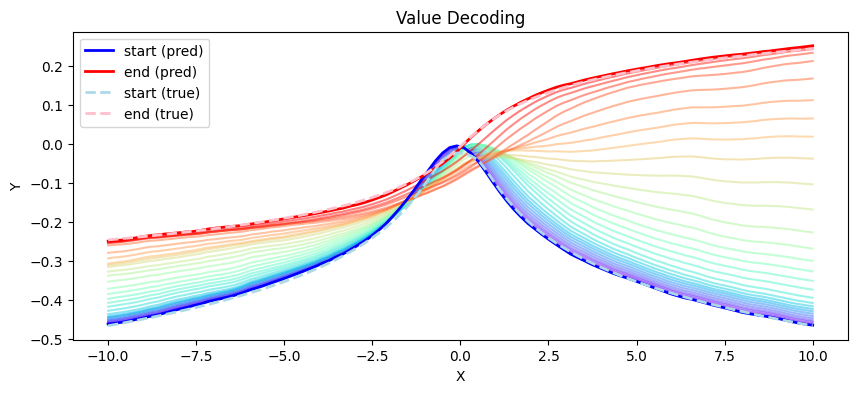

In [77]:
## Value decoding only (for models with no expression decoder)
import src.utils.dev as dev
reload(dev)
from src.utils.dev import plot_value_interpolation, slerp

# Parameters
i, j = 1, 5
num_steps = 30
interp_mode = 'slerp'

# Get data
z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()


print(f'Distance: {np.linalg.norm(z_end - z_start)}')

# Interpolate in latent space
alpha = np.linspace(0, 1, num_steps)
if interp_mode == 'slerp':
    z_interp = slerp(z_start, z_end, alpha)
elif interp_mode == 'linear':
    z_interp = z_start[np.newaxis, ...] * (1 - alpha[:, np.newaxis]) + z_end[np.newaxis, ...] * alpha[:, np.newaxis]
else:
    raise ValueError(f'Interpolation mode {interp_mode} not supported')

# Decode into values and logits
values_interp = model.value_decoder(torch.tensor(z_interp.astype(np.float32)))


fig, ax1 = plt.subplots(figsize=(10, 4))
plot_value_interpolation(ax1, val_x, values_interp, start_true, end_true, 'Value Decoding')

Distance: 2.7642788130242777


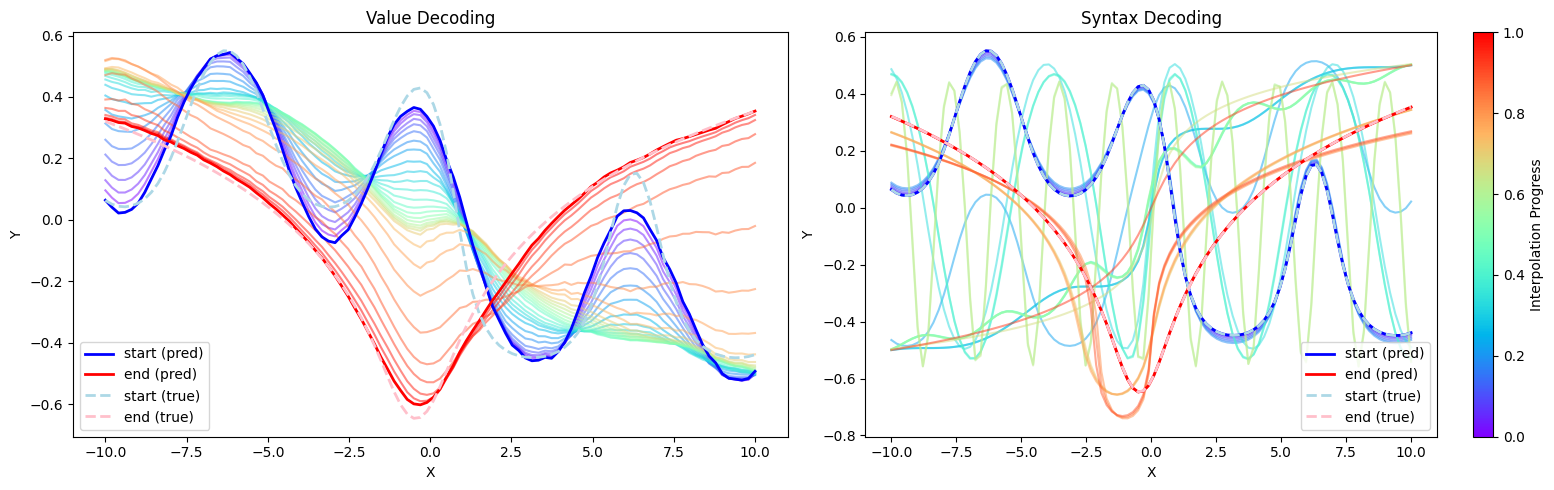

In [24]:
import src.utils.dev as dev
reload(dev)
from src.utils.dev import plot_interpolation

i, j = 2, 4
z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()

plot_interpolation(model, val_x, z_start, z_end, start_true, end_true, value_transform, num_steps=30, interp_mode='slerp')

## Property prediction (SNIP-inspired)

In [81]:
from src.utils.dev import calc_properties, plot_tsne_properties, plot_property_distributions, plot_original_vs_predicted_properties, plot_values_with_property
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt     

BATCH_SIZE = 2**15

properties = np.empty((len(train_loader.dataset), 4))
for i, x in enumerate(data_from_loader(train_loader, 'values', batch_size=BATCH_SIZE)):
    mean, upwardness, oscillations, non_convexity_ratio = calc_properties(x)
    oscillations = np.log(oscillations + 1)
    properties[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = np.array([mean, upwardness, oscillations, non_convexity_ratio]).T

/tmp/ipykernel_3331415/4089937549.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  oscillations = np.log(oscillations + 1)


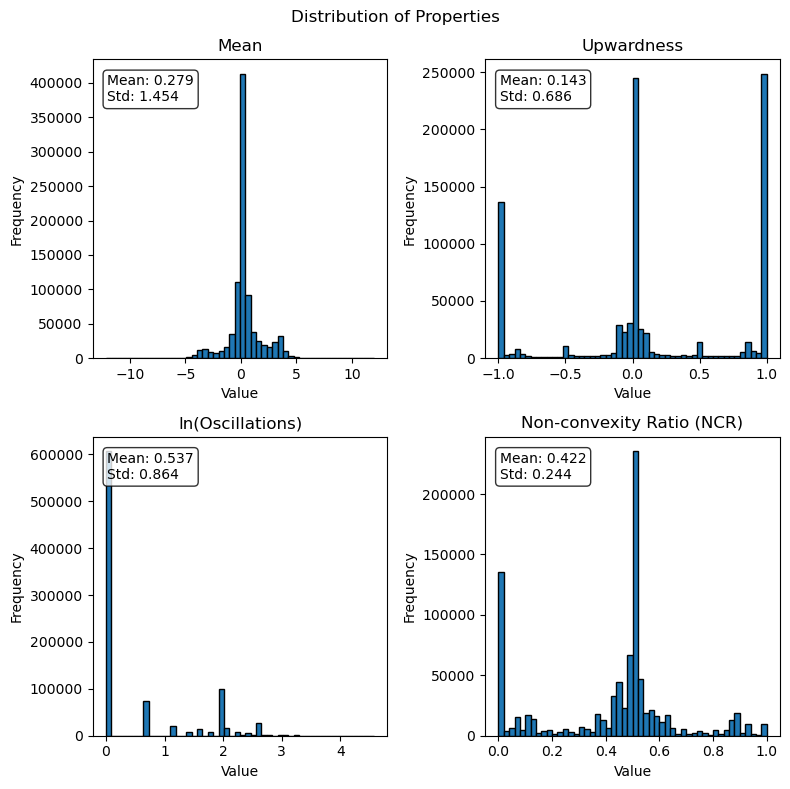

In [82]:
plot_property_distributions(properties)

In [83]:
n = 10000  # Number of samples to plot (tsne is slow!)
pca = PCA(n_components=6)
mu_train_pca = pca.fit_transform(mu_train[:n])
mu_train_2d = TSNE(n_components=2, random_state=42).fit_transform(mu_train_pca)

print(f"Cumulative explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Cumulative explained variance ratio: 0.6979


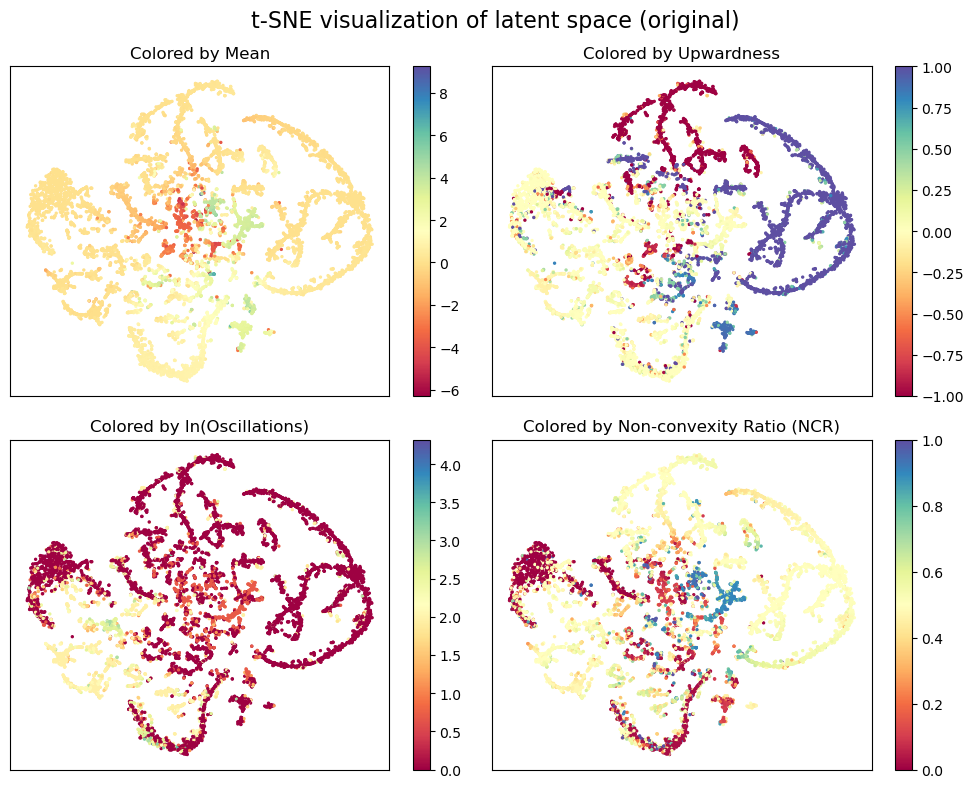

In [84]:
plot_tsne_properties(mu_train_2d, properties[:n], title='t-SNE visualization of latent space (original)')

In [85]:
values_pred = model.value_decoder(torch.tensor(mu_train[:n]).float())
mean, upwardness, oscillations, non_convexity_ratio = calc_properties(values_pred)
properties_pred = np.array([mean, upwardness, torch.log(1+oscillations), non_convexity_ratio]).T

plot_tsne_properties(mu_train_2d, properties_pred[:n], title='t-SNE visualization of latent space (predicted)')

TypeError: 'NoneType' object is not callable

In [86]:
plot_original_vs_predicted_properties(properties[:n], properties_pred)

NameError: name 'properties_pred' is not defined

#### Properties on example

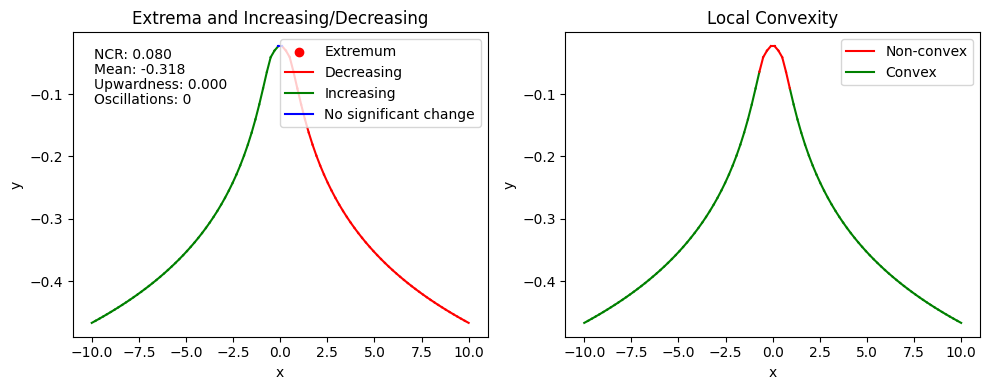

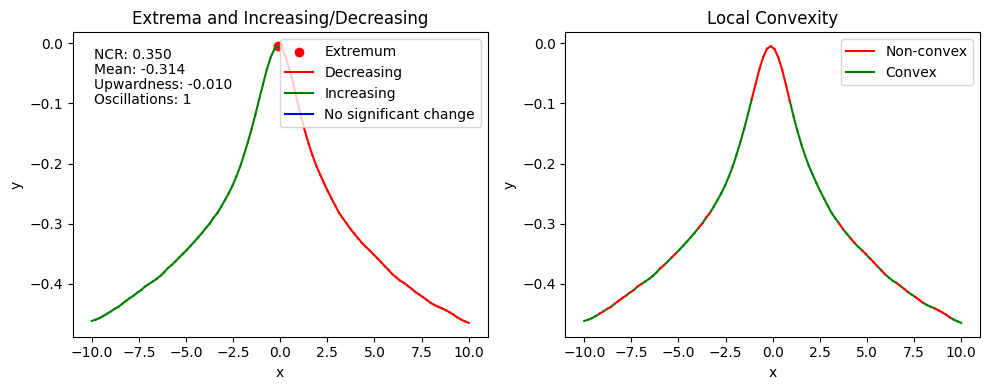

In [95]:
i = 1
y_values = data_from_loader(train_loader, 'values', idx=i)
values_pred = model.value_decoder(torch.tensor(mu_train[i]).unsqueeze(0).float())
plot_values_with_property(y_values)
plot_values_with_property(values_pred)